In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

output_score = list(range(12))
y = [0,0,0,0,1,0,1,1,0,1,1,1]
p = list(range(0,11,1))
p = [i / 10 for i in p]


cost10 = 3
cost11 = 2

theta = list(range(12))
theta = [i+0.5 for i in theta]

def threshold_judge(output_score,threshold):
    output_result = []
    for i in output_score:
        if i >= threshold:
            output_result.append(1)
        else:
            output_result.append(0)
    return output_result

def confusion_matrix(y_ture,y_pred):
    TP = 0
    FN = 0
    FP = 0
    TN = 0
    for i in range(len(y_ture)):
        if y_ture[i] == 1 and y_pred[i] == 1:
            TP += 1
        elif y_ture[i] == 1 and y_pred[i] == 0:
            FN += 1
        elif y_ture[i] == 0 and y_pred[i] == 1:
            FP += 1
        else:
            TN += 1
    return TP,FN,FP,TN

def calculate_FNR_FPR(TP,FP,TN,FN):
    FNR = round(FN/(TP+FN),4)
    FPR = round(FP/(FP+TN),4)
    return FNR,FPR

def calculate_positive_cost(p,cost01,cost10):
    positive_costs = []
    for i in p:
        positive_cost = round((i*cost01)/(i*cost01+(1-i)*cost10),4)
        positive_costs.append(positive_cost)
    return positive_costs

def calcuate_negative_cost(p,cost01,cost11,FNR,FPR):
    negative_costs = []
    for i in p:
        negative_cost = round((FNR*i*cost01+FPR*(1-i)*cost10)/(i*cost01+(1-i)*cost10),4)
        negative_costs.append(negative_cost)
    return negative_costs

output_score = threshold_judge(output_score,0.5)
TP,FN,FP,TN = confusion_matrix(y,output_score)
FNR,FPR = calculate_FNR_FPR(TP,FP,TN,FN)
positive_costs = calculate_positive_cost(p,cost10,cost11)
negative_costs = calcuate_negative_cost(p,cost10,cost11,FNR,FPR)

print(FNR,FPR)
plt.plot(positive_costs,negative_costs,label='Positive Cost')
plt.show()


In [10]:
# 数据分割，去除当前特征
def splitDataset(dataset,index,value):
    # 创建一个新列表，用于存储分割后的数据
    retDataset = []
    # 遍历数据集，将满足条件的数据添加到新列表
    for featVec in dataset:
        if featVec[index] == value:
            reducedFeatVec = featVec[:index]
            reducedFeatVec.extend(featVec[index+1:])
            print(reducedFeatVec)
            retDataset.append(reducedFeatVec)
    return retDataset

dataset = [[0,1,1,1],
           [1,0,1,1],
           [1,0,0,0],
           [1,1,1,0]]

res = splitDataset(dataset,1,0)
print(res)

[1, 1, 1]
[1, 0, 0]
[[1, 1, 1], [1, 0, 0]]


AttributeError: 'Annotation' object has no property 'FontProperties'

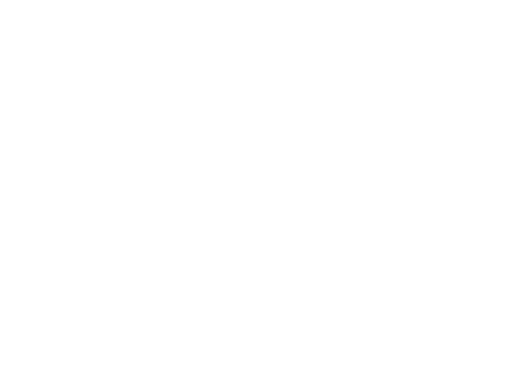

In [4]:
# -*- coding: UTF-8 -*-
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from math import log
import operator



def createDataSet():
	dataSet = [[0, 0, 0, 0, 'no'],						
			[0, 0, 0, 1, 'no'],
			[0, 1, 0, 1, 'yes'],
			[0, 1, 1, 0, 'yes'],
			[0, 0, 0, 0, 'no'],
			[1, 0, 0, 0, 'no'],
			[1, 0, 0, 1, 'no'],
			[1, 1, 1, 1, 'yes'],
			[1, 0, 1, 2, 'yes'],
			[1, 0, 1, 2, 'yes'],
			[2, 0, 1, 2, 'yes'],
			[2, 0, 1, 1, 'yes'],
			[2, 1, 0, 1, 'yes'],
			[2, 1, 0, 2, 'yes'],
			[2, 0, 0, 0, 'no']]
	labels = ['F1-AGE', 'F2-WORK', 'F3-HOME', 'F4-LOAN']		
	return dataSet, labels


def createTree(dataset,labels,featLabels):
	classList = [example[-1] for example in dataset]
	if classList.count(classList[0]) == len(classList):
		return classList[0]
	if len(dataset[0]) == 1:
		return majorityCnt(classList)
	bestFeat = chooseBestFeatureToSplit(dataset)
	bestFeatLabel = labels[bestFeat]
	featLabels.append(bestFeatLabel)
	myTree = {bestFeatLabel:{}}
	del labels[bestFeat]
	featValue = [example[bestFeat] for example in dataset]
	uniqueVals = set(featValue)
	for value in uniqueVals:
		sublabels = labels[:]
		myTree[bestFeatLabel][value] = createTree(splitDataSet(dataset,bestFeat,value),sublabels,featLabels)
	return myTree

def majorityCnt(classList):
	classCount={}
	for vote in classList:
		if vote not in classCount.keys():classCount[vote] = 0
		classCount[vote] += 1
	sortedclassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
	return sortedclassCount[0][0]

def chooseBestFeatureToSplit(dataset):
	numFeatures = len(dataset[0]) - 1
	baseEntropy = calcShannonEnt(dataset)
	bestInfoGain = 0
	bestFeature = -1
	for i in range(numFeatures):
		featList = [example[i] for example in dataset]
		uniqueVals = set(featList)
		newEntropy = 0
		for val in uniqueVals:
			subDataSet = splitDataSet(dataset,i,val)
			prob = len(subDataSet)/float(len(dataset))
			newEntropy += prob * calcShannonEnt(subDataSet)
		infoGain = baseEntropy - newEntropy
		if (infoGain > bestInfoGain):
			bestInfoGain = infoGain
			bestFeature = i	
	return bestFeature
			
			
			
			
			
		
def splitDataSet(dataset,axis,val):
	retDataSet = []
	for featVec in dataset:
		if featVec[axis] == val:
			reducedFeatVec = featVec[:axis]
			reducedFeatVec.extend(featVec[axis+1:])
			retDataSet.append(reducedFeatVec)
	return retDataSet
			
def calcShannonEnt(dataset):
	numexamples = len(dataset)
	labelCounts = {}
	for featVec in dataset:
		currentlabel = featVec[-1]
		if currentlabel not in labelCounts.keys():
			labelCounts[currentlabel] = 0
		labelCounts[currentlabel] += 1
		
	shannonEnt = 0
	for key in labelCounts:
		prop = float(labelCounts[key])/numexamples
		shannonEnt -= prop*log(prop,2)
	return shannonEnt


def getNumLeafs(myTree):
	numLeafs = 0													# 初始化叶结点数
	firstStr = next(iter(myTree))									# 获取第一个特征名
	secondDict = myTree[firstStr]									# 获取第一个特征名对应的子树
	for key in secondDict.keys():									# 遍历子树的每个键
		if type(secondDict[key]).__name__ == 'dict':				# 如果当前键对应的值是字典（子树）
			numLeafs += getNumLeafs(secondDict[key])			# 递归计算子树的叶结点数
		else:														# 如果当前键对应的值不是字典（叶结点）
			numLeafs += 1											# 叶结点数加一
	return numLeafs


def getTreeDepth(myTree):
	maxDepth = 0													# 初始化最大深度
	firstStr = next(iter(myTree))									# 获取第一个特征名
	secondDict = myTree[firstStr]									# 获取第一个特征名对应的子树
	for key in secondDict.keys():									# 遍历子树的每个键
		if type(secondDict[key]).__name__ == 'dict':				# 如果当前键对应的值是字典（子树）
			thisDepth = 1 + getTreeDepth(secondDict[key])			# 递归计算子树的深度，并加一
		else:														# 如果当前键对应的值不是字典（叶结点）
			thisDepth = 1											# 当前深度为一
		if thisDepth > maxDepth: maxDepth = thisDepth				# 更新最大深度
	return maxDepth


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
	arrow_args = dict(arrowstyle="<-")											
	font = FontProperties(fname=r"c:\windows\fonts\simsunb.ttf", size=14)		
	createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',	
		xytext=centerPt, textcoords='axes fraction',
		va="center", ha="center", bbox=nodeType, arrowprops=arrow_args, FontProperties=font)


def plotMidText(cntrPt, parentPt, txtString):
	xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]																
	yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
	createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


def plotTree(myTree, parentPt, nodeTxt):
	decisionNode = dict(boxstyle="sawtooth", fc="0.8")										
	leafNode = dict(boxstyle="round4", fc="0.8")											
	numLeafs = getNumLeafs(myTree)  														
	depth = getTreeDepth(myTree)															
	firstStr = next(iter(myTree))																								
	cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)	
	plotMidText(cntrPt, parentPt, nodeTxt)													
	plotNode(firstStr, cntrPt, parentPt, decisionNode)										
	secondDict = myTree[firstStr]															
	plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD										
	for key in secondDict.keys():								
		if type(secondDict[key]).__name__=='dict':											
			plotTree(secondDict[key],cntrPt,str(key))        								
		else:																														
			plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
			plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
			plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
	plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')  # 创建fig
    fig.clf()  # 清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)  # 去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))  # 获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree))  # 获取决策树层数
    plotTree.xOff = -0.5 / plotTree.totalW  # x偏移
    plotTree.yOff = 1.0  # y偏移
    plotTree(inTree, (0.5, 1.0), '')  # 绘制决策树
    plt.show()


if __name__ == '__main__':
    dataset, labels = createDataSet()
    featLabels = []
    myTree = createTree(dataset, labels, featLabels)
    createPlot(myTree)
	
	
	
	

	
	






						
